# Predicting Readability Amongst Literature for Students Grades 3-12 

This notebook builds multiple machine learning models to predict the readability of litature used in schools. 

In [1]:
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
# import and preview data 
import pandas as pd
df = pd.read_csv('/Users/christianmoya/downloads/commonlitreadabilityprize/train.csv')
df.head()

,id,url_legal,license,excerpt,target,standard_error
0,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009
1,85aa80a4c,NaN,NaN,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805
2,b69ac6792,NaN,NaN,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676
3,dd1000b26,NaN,NaN,And outside before the palace a great garden w...,-1.054013,0.450007
4,37c1b32fb,NaN,NaN,Once upon a time there were Three Bears who li...,0.247197,0.510845


## Clean and Preprocess Data

<b>Removing Null Values</b> 
Right from the get-go, we find null values in the url_legal and license columns. Because those don't add to the readability target, we'll remove both columns. At the end, I'll work with just the excerpt column and target column for the model. 

<b>Cleaning Text Data</b> 
Preparing text data for our models works a bit differently. Below, I tokenize each word, lowercase each capital letter, and remove punctuation marks so that we can properly vectorize our "excerpt" column. 

In [3]:
# define target and data
data = df['excerpt']
target = df['target']

# import necessary libraries 
import re
import nltk 
from nltk.corpus import stopwords 
import string
from nltk import word_tokenize, FreqDist
from sklearn.feature_extraction.text import TfidfVectorizer

# create list of stop words and punctuation 
stopwords_list = stopwords.words('english') + list(string.punctuation)
stopwords_list += ["''", '""', '...', '``']

# create function that removes punctuation and stopwords
def process_text(text):
    text = str(text)
    cleaned = re.sub('\W', ' ', text)
    tokens = nltk.word_tokenize(cleaned)
    stopwords_removed = [token.lower() for token in tokens if token.lower not in stopwords_list]
    joined_words = ' '.join(stopwords_removed)
    return joined_words

df['processed_text'] = df['excerpt'].apply(process_text)
df.head()

,id,url_legal,license,excerpt,target,standard_error,processed_text
0,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009,when the young people returned to the ballroom...
1,85aa80a4c,NaN,NaN,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805,all through dinner time mrs fayre was somewhat...
2,b69ac6792,NaN,NaN,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676,as roger had predicted the snow departed as qu...
3,dd1000b26,NaN,NaN,And outside before the palace a great garden w...,-1.054013,0.450007,and outside before the palace a great garden w...
4,37c1b32fb,NaN,NaN,Once upon a time there were Three Bears who li...,0.247197,0.510845,once upon a time there were three bears who li...


## Vectorizers: TF-IDF and CountVectorizer

Our "processed text" column is now ready to be vectorized. I will work two different vectorizers: TF-IDF and CountVectorizer. 

The <b>TF-IDF</b> Vectorizer calculates the relevance of a word in one document compared to other documents, while the <b>CountVectorizer</b> counts the number of times a word shows up in a document. Relavance may play a larger role when it comes to readability, but we will try both to see. 

### Baseline Model with TF-IDF Vectorizer

In [4]:
# split data into train and test 
from sklearn.model_selection import train_test_split 
target = df['target']
data = df['processed_text']
data_train, data_test, target_train, target_test = train_test_split(data, target, random_state=42)

from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
tfidf_train = vectorizer.fit_transform(data_train)
tfidf_test = vectorizer.transform(data_test)

In [6]:
# create function that builds model and prints out RMSE train and test score
import math
import numpy as np 
from sklearn.metrics import mean_squared_error 
from sklearn import linear_model

def rmse_score(model, data_train, data_test, target_train, target_test):
    
    # build model 
    reg = model
    reg.fit(data_train, target_train)
    
    # make predictions 
    y_pred_train = reg.predict(data_train)
    y_pred_test = reg.predict(data_test)
    
    # calculate rmse score
    mse_train = mean_squared_error(target_train, y_pred_train)
    rmse_train = math.sqrt(mse_train)
    print('rmse train score: ', rmse_train)
    
    mse_test = mean_squared_error(target_test, y_pred_test)
    rmse_test = math.sqrt(mse_test)
    print('rmse test score: ', rmse_test)
    

print('Linear Regression Model with TF-IDF Vectorizer')
rmse_score(linear_model.LinearRegression(), tfidf_train, tfidf_test, target_train, target_test)

Linear Regression Model with TF-IDF Vectorizer
rmse train score:  0.010861320603191336
rmse test score:  0.7392255161334383


## Parameter Tuning 

We see that our model has a huge problem with overfitting since the RMSE score for our training data is much lower that our RMSE score for our testing data. We'll explore more models later but in the meantime, we can also play with the parameters to see which might give us the lowest RMSE score, starting with the max features parameter.

### Testing tf-idf with Max Features

Max Features is one parameter we can tune. Below we're testing for max features between 100 and 10,000. 

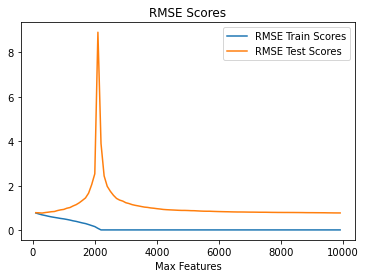

In [7]:
import matplotlib.pyplot as plt

# create list of RMSE scores 
rmse_train_scores = []
rmse_test_scores = []

# create function that tests for different max features 
def tfidf_maxfeatures(data, target, n):
    
    #split data into train and test
    data_train, data_test, target_train, target_test = train_test_split(data, target, random_state=42)
    
    # vectorize text data 
    vectorizer = TfidfVectorizer(max_features = n)
    tfidf_train = vectorizer.fit_transform(data_train)
    tfidf_test = vectorizer.transform(data_test)
    
    # fit LinearRegression model 
    reg = linear_model.LinearRegression()
    reg.fit(tfidf_train, target_train)
    
    # predict target
    y_pred_train = reg.predict(tfidf_train)
    y_pred_test = reg.predict(tfidf_test)
    
    # check RMSE score 
    rme_train = mean_squared_error(y_pred_train, target_train)
    rmse_train = math.sqrt(rme_train)
    rmse_train_scores.append(rmse_train)
    #print('RMSE Train Score with {} Max Features: '.format(n), rmse_train)
    
    rme_test = mean_squared_error(y_pred_test, target_test)
    rmse_test = math.sqrt(rme_test)
    rmse_test_scores.append(rmse_test)
    #print('RMSE Test Score with {} Max Features: '.format(n), rmse_test)
    
# plot RMSE scores for different number of max features 
def plot_maxfeatures(lower, upper, skip):
    for n in range(lower,upper,skip):
        tfidf_maxfeatures(df['processed_text'], df['target'], n)
        
    plt.plot(range(lower,upper,skip), rmse_train_scores, label='RMSE Train Scores');
    plt.plot(range(lower,upper,skip), rmse_test_scores, label='RMSE Test Scores')
    plt.legend()
    plt.title('RMSE Scores')
    plt.xlabel('Max Features');
    
plot_maxfeatures(100,10000,100)

When our max features is set at 2000, we find that our test scores peak with an RMSE score above 8 and our train scores reach somewhat of an elbow and stabalizes close to 1. We still see that we have a problem with overfitting since the lines never seem to merge. 

### Test for Unigrams, Bigrams, and Trigrams

With our text data, we'll also test to see whether including bigrams and trigrams can help our model. 

In [9]:
# test with unigrams, bigrams, and trigrams 
vectorizer3 = TfidfVectorizer(ngram_range=(1,3), max_features=4000)
tfidf_train3 = vectorizer3.fit_transform(data_train)
tfidf_test3 = vectorizer3.transform(data_test)

print('Linear Regression Model with TF-IDF unigrams, bigrams, and trigrams')
rmse_score(linear_model.LinearRegression(), tfidf_train3, tfidf_test3, target_train, target_test)

Linear Regression Model with TF-IDF unigrams, bigrams, and trigrams
rmse train score:  0.010861320603192918
rmse test score:  1.0186970489579505


Though the RMSE scores are closer together than our baseline, it looks like we're still overfitting our training data. We'll use a Ridge Regerssion model to help by desensitize our model to the training data.

## Ridge Regression Model

Ridge Regression is another linear model that desensitizes the model to our training data. Hopefully this helps with our overfitting problem. 

In [10]:
from sklearn import linear_model 
vectorizer4 = TfidfVectorizer(ngram_range=(1,3))
tfidf_train4 = vectorizer4.fit_transform(data_train)
tfidf_test4 = vectorizer4.transform(data_test)

print('Ridge Regression Model with TF-IDF Vectorizer Unigrams, Bigrams, Trigrams')
rmse_score(linear_model.Ridge(alpha=.5), tfidf_train4, tfidf_test4, target_train, target_test)

Ridge Regression Model with TF-IDF Vectorizer Unigrams, Bigrams, Trigrams
rmse train score:  0.2662557445942855
rmse test score:  0.7145901182830405


In [11]:
# test for max features in ridge regression 
vectorizer5 = TfidfVectorizer(max_features=50000, ngram_range=(1,3))
tfidf_train5 = vectorizer5.fit_transform(data_train)
tfidf_test5 = vectorizer5.transform(data_test)

print('Ridge Regression Model with TF-DF Vectorizer with 50,000 Max Featuers')
rmse_score(linear_model.Ridge(alpha=.5), tfidf_train5, tfidf_test5, target_train, target_test)

Ridge Regression Model with TF-DF Vectorizer with 50,000 Max Featuers
rmse train score:  0.2693671405085464
rmse test score:  0.698200648071989


So far, this model holds the lowest RMSE test score of 0.698 compared to our baseline of .739. I'm instantiating a new model below so we can explore its coefficients. 

In [28]:
reg5 = linear_model.Ridge(alpha=0.5)
reg5.fit(tfidf_train5, target_train)

Ridge(alpha=0.5)

## Testing with CountVectorizer

So far, we've tested with the TF-IDF vectorizer, and had a clear problem with over-fitting. However, we were able to lower our RMSE score by 5%. This time, we'll test with a CountVectorizer instead to see if it will help with our RMSE score. 

In [12]:
# baseline CountVectorizer model 
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer()
cv_train = cv.fit_transform(data_train)
cv_test = cv.transform(data_test)

print('Linear Regression Model with Count Vectorizer')
rmse_score(linear_model.LinearRegression(), cv_train, cv_test, target_train, target_test)

Linear Regression Model with Count Vectorizer
rmse train score:  0.010861320603196445
rmse test score:  0.8136934148949335


In [13]:
# CountVectorizer with Ridge Regression 
print('Ridge Regression Model with Count Vectorizer')
rmse_score(linear_model.Ridge(alpha=0.5), cv_train, cv_test, target_train, target_test)

Ridge Regression Model with Count Vectorizer
rmse train score:  0.012389617353902855
rmse test score:  0.8117343814496976


The CountVectorizer doesn't seem to perform any better than the TF-IDF vectorizer. We'll continue trying both for the Random Forest Regression model, but may continue parameter tuning with TF-IDF. 

### Random Forest Regression Model

Let's see if a Random Forest Regression Model will perform higher than the Linear Regression model and the Ridge Regression model.

In [14]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()
model.fit(cv_train, target_train)

y_pred_train8 = model.predict(cv_train)
y_pred_test8 = model.predict(cv_test)

rme_train8 = mean_squared_error(y_pred_train8, target_train)
rmse_train8 = math.sqrt(rme_train8)
print('Count Vectorizer with Random Forest Regression Training RMSE: ', rmse_train8)

rme_test8 = mean_squared_error(y_pred_test8, target_test)
rmse_test8 = math.sqrt(rme_test8)
print('Count Vectorizer with Random Forest Regression Test RMSE: ', rmse_test8)

Count Vectorizer with Random Forest Regression Training RMSE:  0.3048182485135861
Count Vectorizer with Random Forest Regression Test RMSE:  0.8128639969723552


In [15]:
# create function that tests for different n_estimators 
def random_forest_regressor(data_train, data_test, target_train, target_test, n):
    
    # instantiate model 
    model = RandomForestRegressor(n_estimators=n)
    model.fit(data_train, target_train )
    
    # make predictions 
    y_pred_train = model.predict(data_train)
    y_pred_test = model.predict(data_test)
    
    # calculate rmse scores 
    rme_train = mean_squared_error(y_pred_train, target_train)
    rmse_train = math.sqrt(rme_train)
    
    rme_test = mean_squared_error(y_pred_test, target_test)
    rmse_test = math.sqrt(rme_test)
    
    return rmse_train, rmse_test

# create list of rmse scores 
rmse_train_scores = []
rmse_test_scores = []

for i in range(10,100,10):
    rmse_train, rmse_test = random_forest_regressor(cv_train, cv_test, target_train, target_test, i)
    rmse_train_scores.append(rmse_train)
    rmse_test_scores.append(rmse_test)

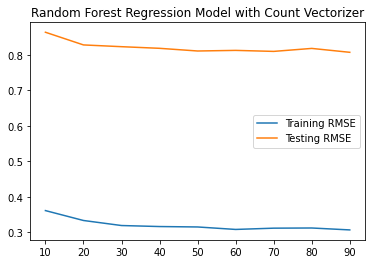

In [16]:
plt.plot(range(10,100,10), rmse_train_scores, label='Training RMSE')
plt.plot(range(10,100,10), rmse_test_scores, label='Testing RMSE')
plt.legend()
plt.title('Random Forest Regression Model with Count Vectorizer');

Our Random Forest Regression model doens't seem to beat our Ridge Regression. 

In [18]:
print('TF-IDF Vectorizer with Random Forest Regression Model')
rmse_score(RandomForestRegressor(), tfidf_train5, tfidf_test5, target_train, target_test)

TF-IDF Vectorizer with Random Forest Regression Model
rmse train score:  0.30351994306024277
rmse test score:  0.8036740080157325


### Experiment with GridSearchCV

Because RidgeRegression had the best performing RMSE score, we'll do a grid search to see which parameters work best. 

In [21]:
from sklearn.model_selection import GridSearchCV
parameters = {'solver':['auto', 'sag', 'sparse_cg'], 'alpha':[1,2], 'normalize':[True,False]}
reg9 = linear_model.Ridge()
gs = GridSearchCV(reg9, parameters, scoring='neg_root_mean_squared_error')
gs.fit(tfidf_train5, target_train)
pd.DataFrame(gs.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_normalize,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.035230,0.006360,0.000689,0.000162,1,True,auto,"{'alpha': 1, 'normalize': True, 'solver': 'auto'}",-0.765700,-0.741329,-0.800775,-0.731963,-0.764206,-0.760794,0.023851,4
1,0.163348,0.039011,0.000741,0.000019,1,True,sag,"{'alpha': 1, 'normalize': True, 'solver': 'sag'}",-0.976906,-0.923511,-0.976019,-0.874292,-0.935100,-0.937166,0.038033,11
2,0.030789,0.000912,0.000627,0.000060,1,True,sparse_cg,"{'alpha': 1, 'normalize': True, 'solver': 'spa...",-0.765700,-0.741329,-0.800775,-0.731963,-0.764206,-0.760794,0.023851,4
3,0.025218,0.002154,0.000612,0.000026,1,False,auto,"{'alpha': 1, 'normalize': False, 'solver': 'au...",-0.744768,-0.715074,-0.800368,-0.716109,-0.743105,-0.743885,0.030962,1
4,0.096041,0.003959,0.000747,0.000032,1,False,sag,"{'alpha': 1, 'normalize': False, 'solver': 'sag'}",-0.744833,-0.715222,-0.800364,-0.716201,-0.743188,-0.743962,0.030917,3
5,0.021417,0.000431,0.000611,0.000026,1,False,sparse_cg,"{'alpha': 1, 'normalize': False, 'solver': 'sp...",-0.744768,-0.715074,-0.800368,-0.716109,-0.743105,-0.743885,0.030962,1
6,0.026062,0.001983,0.000661,0.000074,2,True,auto,"{'alpha': 2, 'normalize': True, 'solver': 'auto'}",-0.767703,-0.742777,-0.802560,-0.732519,-0.765659,-0.762244,0.024205,6
7,0.172137,0.050622,0.000733,0.000101,2,True,sag,"{'alpha': 2, 'normalize': True, 'solver': 'sag'}",-0.978720,-0.925137,-0.977626,-0.875768,-0.936808,-0.938812,0.038118,12
8,0.029717,0.001921,0.000701,0.000093,2,True,sparse_cg,"{'alpha': 2, 'normalize': True, 'solver': 'spa...",-0.767703,-0.742777,-0.802560,-0.732519,-0.765659,-0.762244,0.024205,6
9,0.020869,0.000765,0.000627,0.000074,2,False,auto,"{'alpha': 2, 'normalize': False, 'solver': 'au...",-0.773801,-0.741109,-0.823595,-0.737651,-0.767367,-0.768705,0.030876,8


In [22]:
print('TF-IDF Vectorizer with Ridge Regression and Best Parameters Based on GridSearch')
rmse_score(linear_model.Ridge(alpha=1, normalize=False, solver='sparse_cg'), tfidf_train5, tfidf_test5, target_train, target_test)

TF-IDF Vectorizer with Ridge Regression and Best Parameters Based on GridSearch
rmse train score:  0.3935140122416576
rmse test score:  0.7062878513705304


### Explore Feature Importance 

Ridge Regression Model with a TF-IDF vectorizer with 50,000 had the lowest rmse, so we'll explore that model for feature importance. 

In [30]:
term_coef = pd.DataFrame(zip(reg5.coef_, vectorizer5.get_feature_names()), columns=['coef', 'term'])
sorted_df = term_coef.sort_values(by=['coef'])
sorted_df.head()

,coef,term
26596,-3.585168,of
3939,-1.756629,as
19058,-1.655534,in
37643,-1.548362,the
48784,-1.424915,with


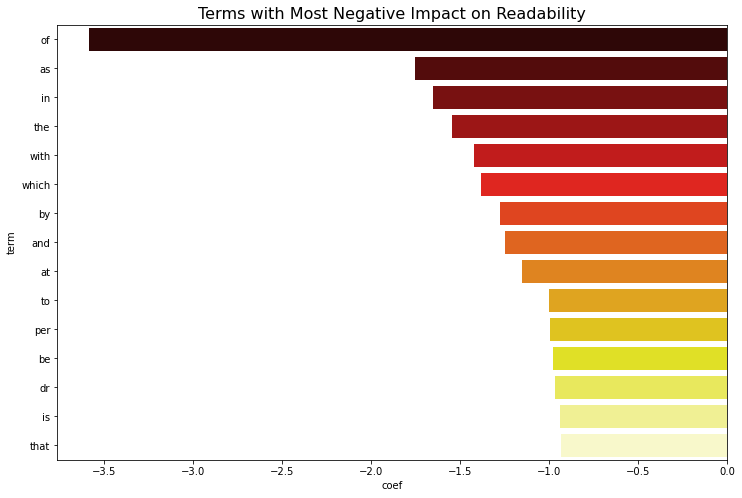

In [31]:
import seaborn as sns 
plt.subplots(figsize=[12,8])
sns.barplot(x='coef', y='term', data=sorted_df.head(15), palette='hot')
plt.title('Terms with Most Negative Impact on Readability', fontsize=16);

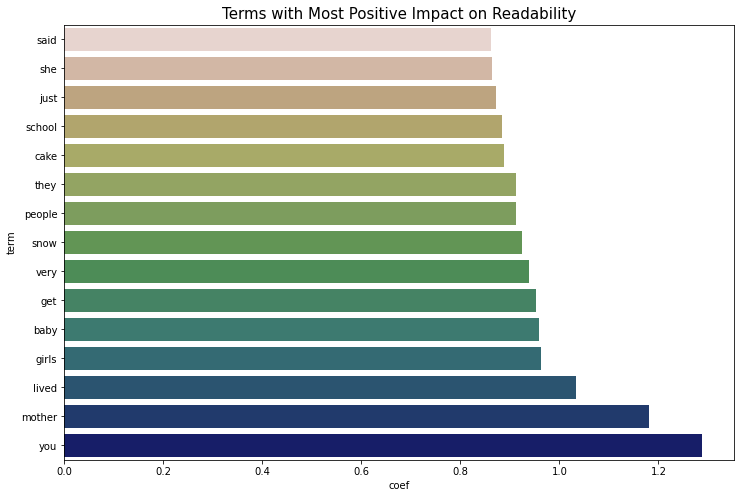

In [32]:
plt.subplots(figsize=[12,8])
sns.barplot(x='coef', y='term', data=sorted_df.tail(15), palette='gist_earth_r')
plt.title('Terms with Most Positive Impact on Readability', fontsize=15);

## Conclusion 

After iterating with 2 vectorizers, 3 regression models and a grid search, our lowest RMSE score came out to .698 using the TF-IDF vectorizer and a Ridge Regression Model, a score 5% lower than our baseline. When we explore feature importance, we find words like "you", "mother", and "lived" increase the readability score. In contrast, prepositional words like "of", "as", and "in" decreased the readability score. The results tell me that easier texts are told like stories, and more difficult texts have more prepositional words, so the language is not as direct. 